In [68]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Datasets, preprocessing, and metrics
from sklearn import datasets
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, cohen_kappa_score
#from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Useful Functions
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Ensemble Classifiers
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

# import load_dataset
# from HoTdiagram import HoTdiagram
from AMEnsembleMC import CvECNN, CvHNN, CvECAM, MvHNN_Ensemble, MvRCNN_Ensemble

In [69]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [70]:
def EvalClassifiers(Name, X, y, n_splits=10, score = f1_score):
    
    #report = pd.DataFrame()
    
    df = pd.DataFrame()
    
    df_acc = pd.DataFrame()
    df_f1 = pd.DataFrame()
    
    df_params = pd.DataFrame()
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
    for train_index, test_index in skf.split(X, y):
        
        df_sim = pd.DataFrame()
        df_sim_acc = pd.DataFrame()
        df_sim_f1 = pd.DataFrame()
        #report_sim = pd.DataFrame()
        
        df_params_sim = pd.DataFrame()
        
        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]
        
        # Process the data
        scaler = StandardScaler()
        Xtr = scaler.fit_transform(Xtr)
        Xte = scaler.transform(Xte)
        
        rf = RandomForestClassifier(n_estimators=30)
        rf.fit(Xtr,ytr)
        ypred = rf.predict(Xte)
        
        # n_estimators=10,learning_rate=.1,random_state=0
        
        # Gradient Boosting
        gboost = GradientBoostingClassifier().fit(Xtr,ytr)
        y_pred = gboost.predict(Xte)
        df_sim["Gradient Boost"] = [cohen_kappa_score(yte,ypred)]
        df_sim_acc["Gradient Boost"] =  [accuracy_score(yte,ypred)]
        df_sim_f1["Gradient Boost"] =  [f1_score(yte,ypred, average="macro")]
        
        #report_sim["Gradient Boost"] = [metrics.classification_report(yte, ypred, digits=3)]

        df_sim["Random Forest"] = [cohen_kappa_score(yte,ypred)]
        df_sim_acc["Random Forest"] =  [accuracy_score(yte,ypred)]
        df_sim_f1["Random Forest"] =  [f1_score(yte,ypred, average="macro")]
        
        #report_sim["Random Forest"] = [metrics.classification_report(yte, ypred, digits=3)]
        
        ecam = MvRCNN_Ensemble(classifiers = rf.estimators_, alpha = 10).fit(Xtr,ytr)
        ypred = ecam.predict(Xte)

        df_sim["RCNN"] = [cohen_kappa_score(yte,ypred)]
        df_sim_acc["RCNN"] =  [accuracy_score(yte,ypred)]
        df_sim_f1["RCNN"] =  [f1_score(yte,ypred, average="macro")]
        
        #report_sim["RCNN"] = [metrics.classification_report(yte, ypred, digits=3)]
        
        
        hnn = MvHNN_Ensemble(classifiers = rf.estimators_).fit(Xtr,ytr)
        ypred = hnn.predict(Xte)

        df_sim["HNN"] = [cohen_kappa_score(yte,ypred)]
        df_sim_acc["HNN"] =  [accuracy_score(yte,ypred)]
        df_sim_f1["HNN"] =  [f1_score(yte,ypred, average="macro")]
        
        #report["HNN"] = [metrics.classification_report(yte, ypred, digits=3)]
        #parameters = {'classifiers': [rf.estimators_] , 'RCNN': [CvECAM] ,  'alpha':[0.01, 0.1, 0.5, 1, 5, 10, 20, 50]}
        #ECAM_grid = GridSearchCV(MvRCNN_Ensemble(),parameters,cv = 5).fit(Xtr,ytr)
        #y_pred = ECAM_grid.predict(Xte)
        #df_sim["Exp. RCNN + Grid Search"] = [score(yte,y_pred)]
        #df_sim_acc["Exp. RCNN + Grid Search"] =  [accuracy_score(yte,ypred)]
        #df_sim_f1["Exp. RCNN + Grid Search"] =  [f1_score(yte,ypred, average="macro")]
          
        df_f1 = pd.concat([df_f1,df_sim_f1])
        df_acc =  pd.concat([df_acc,df_sim_acc])
        df = pd.concat([df,df_sim])
        
        #report = pd.concat([report,report_sim])
        
    df.to_csv("CSVs/%s.csv" % Name)
    df_f1.to_csv("CSVs/%s.csv" % Name)
    df_acc.to_csv("CSVs/%s.csv" % Name)
    
    print(df)
    
    #return df,df_f1,df_acc, df_params, report
    return df,df_f1,df_acc, df_params

In [71]:
AllDataSets = [("wine","wine",1),("iris","iris",1),
    ("primary-tumor","primary-tumor",1),
    ("dna","dna",1),("steel-plates-fault","steel-plates-fault",3),("segment","segment",3),("synthetic_control","synthetic_control",1),
    ("cardiotocography","cardiotocography",1),("balance-scale","balance-scale",1),
    ("satimage","satimage",1),("cnae-9","cnae-9",1),  
    ("arrhythmia","arrhythmia",1),("cjs","cjs",3),
    ("gesture","GesturePhaseSegmentationProcessed",1),("theorem","first-order-theorem-proving",1),
    ("dmft","analcatdata_dmft",1),("anauthor","analcatdata_authorship",1),
    ("morphologic","mfeat-morphological",1),("optdigits","optdigits",1),("mfeat-fourier","mfeat-fourier",2),
    ("mfeat-karhunen","mfeat-karhunen",2),("micro-mass","micro-mass",2),("cmc","cmc",1),("braziltourism","braziltourism",1),("texture","one-hundred-plants-texture",1),
    ("miceprotein","miceprotein",4),
    ("chess","jungle_chess_2pcs_raw_endgame_complete",1),("gas","gas-drift",1),("wave","waveform-5000",1)]

# Los data sets que demoran absurdamente:
# ("mnist_784","mnist_784",1)
# ("har","har",1)
# ("fabert","fabert",1)
#("connect-4","connect-4",2)
#("OVA_Breast","OVA_Breast",1)
# ("eating","eating",1)
# ("Indian_pines","Indian_pines",1)
# ("dilbert","dilbert",1)
# ("rsct","rsctc2010_5",1)
# ("amazon-commerce-reviews","amazon-commerce-reviews",1)
#("eating","eating",1)

In [72]:
### Just for test
# jungle_chess_2pcs_raw_endgame_complete (algun problema tiene)
#AllDataSets = [("wine","wine",1),("iris","iris",1)]
#len(AllDataSets )

In [77]:
data = pd.DataFrame()
data_f1 = pd.DataFrame()
data_acc = pd.DataFrame()
data_params = pd.DataFrame()
report= pd.DataFrame()
for name, dataset, version in AllDataSets:  #so mudar aqui depois
#for name, dataset, version in TestDataSets:
    start_time = time.time()
    print("\nProcessing dataset: ",name)
    X, y = datasets.fetch_openml(dataset,version=version,return_X_y = True)
    
    ## Imput missing data
    X = SimpleImputer().fit_transform(X)
    ## Convert categorical class names to numbers
    y = LabelEncoder().fit_transform(y)
    
    #df, df_params, report = EvalClassifiers(name, X, y)
    df,df_f1,df_acc, df_params = EvalClassifiers(name, X, y)
    
    data = pd.concat([data,df.rename(index={0:name})])
    data_f1 = pd.concat([data_f1,df_f1.rename(index={0:name})])
    data_acc = pd.concat([data_acc,df_acc.rename(index={0:name})])
    
    data_params = pd.concat([data_params,df_params.rename(index={0:name})])
    
    #report = pd.concat([report,reportf .rename(index={0:name})])
    
    data.to_csv("CSVs/MultiClassDataSets.csv")
    data_f1.to_csv("CSVs/MultiClassDataSets2.csv")
    data_acc.to_csv("CSVs/MultiClassDataSet3.csv")
    
    #report.to_csv("CSVs/reporte.csv")
    
    print("\nTime to process the dataset: %2.2f seconds." % (time.time() - start_time))



Processing dataset:  wine
   Gradient Boost  Random Forest      RCNN       HNN
0        0.920168       0.920168  0.920168  0.920168
0        1.000000       1.000000  1.000000  1.000000
0        1.000000       1.000000  1.000000  1.000000
0        0.834862       0.834862  0.916667  0.916667
0        1.000000       1.000000  0.915094  1.000000
0        0.916667       0.916667  0.916667  0.916667
0        1.000000       1.000000  1.000000  1.000000
0        1.000000       1.000000  1.000000  1.000000
0        1.000000       1.000000  1.000000  1.000000
0        0.902439       0.902439  1.000000  1.000000

Time to process the dataset: 4.19 seconds.

Processing dataset:  iris
   Gradient Boost  Random Forest  RCNN  HNN
0             1.0            1.0   1.0  1.0
0             0.6            0.6   0.7  0.7
0             0.9            0.9   0.9  0.9
0             1.0            1.0   0.9  0.9
0             0.8            0.8   0.9  0.9
0             1.0            1.0   1.0  1.0
0          

   Gradient Boost  Random Forest      RCNN       HNN
0        0.520585       0.520585  0.502163  0.505920
0        0.514273       0.514273  0.506281  0.504359
0        0.540155       0.540155  0.510759  0.509855
0        0.528427       0.528427  0.496333  0.501426
0        0.546998       0.546998  0.490655  0.483422
0        0.509087       0.509087  0.491489  0.492035
0        0.527551       0.527551  0.490396  0.490944
0        0.524905       0.524905  0.510210  0.509253
0        0.530674       0.530674  0.495892  0.499454
0        0.574116       0.574116  0.496543  0.489872

Time to process the dataset: 195.84 seconds.

Processing dataset:  theorem
   Gradient Boost  Random Forest      RCNN       HNN
0        0.543380       0.543380  0.517778  0.521800
0        0.467119       0.467119  0.427084  0.427715
0        0.462015       0.462015  0.443112  0.414689
0        0.500922       0.500922  0.465992  0.458739
0        0.461162       0.461162  0.402756  0.403532
0        0.501400      

   Gradient Boost  Random Forest      RCNN       HNN
0        0.631720       0.631720  0.597615  0.596923
0        0.626177       0.626177  0.604363  0.601145
0        0.624197       0.624197  0.590735  0.587391
0        0.619759       0.619759  0.584130  0.586630
0        0.617094       0.617094  0.592034  0.590849
0        0.604381       0.604381  0.581110  0.584334
0        0.625107       0.625107  0.595037  0.592656
0        0.610137       0.610137  0.577139  0.580600
0        0.620230       0.620230  0.596980  0.593162
0        0.621159       0.621159  0.595653  0.595958

Time to process the dataset: 130.51 seconds.

Processing dataset:  gas
   Gradient Boost  Random Forest      RCNN       HNN
0        0.992166       0.992166  0.990425  0.990425
0        0.996516       0.996516  0.995645  0.995646
0        0.990417       0.990417  0.986933  0.986933
0        0.989543       0.989543  0.989540  0.990411
0        0.995643       0.995643  0.996514  0.995642
0        0.989531       0.9

In [78]:
data

,Gradient Boost,Random Forest,RCNN,HNN
wine,0.920168,0.920168,0.920168,0.920168
wine,1.000000,1.000000,1.000000,1.000000
wine,1.000000,1.000000,1.000000,1.000000
wine,0.834862,0.834862,0.916667,0.916667
wine,1.000000,1.000000,0.915094,1.000000
...,...,...,...,...
wave,0.801633,0.801633,0.789616,0.783564
wave,0.744485,0.744485,0.738504,0.750491
wave,0.753515,0.753515,0.780616,0.768561
wave,0.759614,0.759614,0.762641,0.759596


In [79]:
data_f1

,Gradient Boost,Random Forest,RCNN,HNN
wine,0.952137,0.952137,0.952137,0.952137
wine,1.000000,1.000000,1.000000,1.000000
wine,1.000000,1.000000,1.000000,1.000000
wine,0.888889,0.888889,0.944056,0.944056
wine,1.000000,1.000000,0.940741,1.000000
...,...,...,...,...
wave,0.867740,0.867740,0.859507,0.855857
wave,0.829825,0.829825,0.825607,0.833788
wave,0.835698,0.835698,0.853475,0.845657
wave,0.839143,0.839143,0.840772,0.839352


In [80]:
data_acc

,Gradient Boost,Random Forest,RCNN,HNN
wine,0.947368,0.947368,0.947368,0.947368
wine,1.000000,1.000000,1.000000,1.000000
wine,1.000000,1.000000,1.000000,1.000000
wine,0.888889,0.888889,0.944444,0.944444
wine,1.000000,1.000000,0.944444,1.000000
...,...,...,...,...
wave,0.867735,0.867735,0.859719,0.855711
wave,0.829659,0.829659,0.825651,0.833667
wave,0.835671,0.835671,0.853707,0.845691
wave,0.839679,0.839679,0.841683,0.839679


## Construyendo las tablas

In [90]:
def function_tablas(data,AllDataSets):
    # transpongo para realizar la media por data set
    data_new = data.transpose()

    # Metodos
    Methods = ["Gradient Boost","Random Forest","RCNN","HNN"]
    #Methods = ["Random Forest","Identity RCAM","Exponential RCAM","Exp. RCAM + Grid Search"]
    # Cantidad de datasets y métodods
    #L = len(TestDataSets)
    L = len(AllDataSets)
    #print(L)
    nm = len(Methods)

    # Matriz final
    M = list()
    Total = list()
    # Elijo un metodo
    for j in range(nm):
        # Recorro todos los data set
        M = list()
        for i in range(L):
            #summary = data_new[TestDataSets[i][0]].iloc[j, :].describe()
            summary = data_new[AllDataSets[i][0]].iloc[j, :].describe()        
            media = summary[1]
            std   = summary[2]
                        # metodo               # resultado data set i
            M.append('$'+str(round(summary[1],3))+ r" \pm "+ str(round(summary[2],3))+'$')
        #print(np.array(M).shape)
        Total.append(M)
    return Total

In [ ]:
# Tabela 1

In [91]:
Total = function_tablas(data,AllDataSets)

In [92]:
Matrix_Total = np.array(Total).T
print(Matrix_Total.shape)
index = list()
for i in range(L):
    index.append(AllDataSets[i][0])
datasetfinal = pd.DataFrame({Methods[0]: Matrix_Total[:, 0], Methods[1]: Matrix_Total[:, 1],Methods[2]: Matrix_Total[:, 2], Methods[3]: Matrix_Total[:, 3]}, index=index)

(29, 4)


In [93]:
datasetfinal

,Gradient Boost,Random Forest,RCNN,HNN
wine,$0.957 \pm 0.06$,$0.957 \pm 0.06$,$0.967 \pm 0.043$,$0.975 \pm 0.04$
iris,$0.92 \pm 0.132$,$0.92 \pm 0.132$,$0.93 \pm 0.095$,$0.93 \pm 0.095$
primary-tumor,$0.345 \pm 0.076$,$0.345 \pm 0.076$,$0.199 \pm 0.071$,$0.201 \pm 0.08$
dna,$0.911 \pm 0.015$,$0.911 \pm 0.015$,$0.921 \pm 0.016$,$0.915 \pm 0.011$
steel-plates-fault,$0.708 \pm 0.051$,$0.708 \pm 0.051$,$0.635 \pm 0.054$,$0.641 \pm 0.051$
segment,$0.968 \pm 0.013$,$0.968 \pm 0.013$,$0.947 \pm 0.019$,$0.952 \pm 0.021$
synthetic_control,$0.972 \pm 0.03$,$0.972 \pm 0.03$,$0.958 \pm 0.024$,$0.964 \pm 0.026$
cardiotocography,$1.0 \pm 0.0$,$1.0 \pm 0.0$,$0.996 \pm 0.006$,$0.996 \pm 0.007$
balance-scale,$0.703 \pm 0.049$,$0.703 \pm 0.049$,$0.662 \pm 0.042$,$0.658 \pm 0.047$
satimage,$0.893 \pm 0.014$,$0.893 \pm 0.014$,$0.852 \pm 0.014$,$0.854 \pm 0.015$


In [ ]:
# Tabela 2

In [94]:
Total = function_tablas(data_f1,AllDataSets)

In [95]:
Matrix_Total = np.array(Total).T
print(Matrix_Total.shape)
index = list()
for i in range(L):
    index.append(AllDataSets[i][0])
datasetfinal = pd.DataFrame({Methods[0]: Matrix_Total[:, 0], Methods[1]: Matrix_Total[:, 1],Methods[2]: Matrix_Total[:, 2], Methods[3]: Matrix_Total[:, 3]}, index=index)

(29, 4)


In [96]:
datasetfinal

,Gradient Boost,Random Forest,RCNN,HNN
wine,$0.973 \pm 0.039$,$0.973 \pm 0.039$,$0.978 \pm 0.028$,$0.984 \pm 0.026$
iris,$0.945 \pm 0.091$,$0.945 \pm 0.091$,$0.953 \pm 0.064$,$0.953 \pm 0.064$
primary-tumor,$0.26 \pm 0.066$,$0.26 \pm 0.066$,$0.144 \pm 0.046$,$0.145 \pm 0.046$
dna,$0.938 \pm 0.011$,$0.938 \pm 0.011$,$0.945 \pm 0.012$,$0.941 \pm 0.009$
steel-plates-fault,$0.791 \pm 0.047$,$0.791 \pm 0.047$,$0.685 \pm 0.055$,$0.684 \pm 0.053$
segment,$0.973 \pm 0.011$,$0.973 \pm 0.011$,$0.955 \pm 0.016$,$0.958 \pm 0.018$
synthetic_control,$0.977 \pm 0.025$,$0.977 \pm 0.025$,$0.965 \pm 0.02$,$0.97 \pm 0.022$
cardiotocography,$1.0 \pm 0.0$,$1.0 \pm 0.0$,$0.994 \pm 0.012$,$0.992 \pm 0.015$
balance-scale,$0.597 \pm 0.016$,$0.597 \pm 0.016$,$0.589 \pm 0.014$,$0.588 \pm 0.016$
satimage,$0.894 \pm 0.011$,$0.894 \pm 0.011$,$0.849 \pm 0.013$,$0.853 \pm 0.014$


In [97]:
# Tabela 3

In [98]:
Total = function_tablas(data_acc,AllDataSets)

In [99]:
Matrix_Total = np.array(Total).T
print(Matrix_Total.shape)
index = list()
for i in range(L):
    index.append(AllDataSets[i][0])
datasetfinal = pd.DataFrame({Methods[0]: Matrix_Total[:, 0], Methods[1]: Matrix_Total[:, 1],Methods[2]: Matrix_Total[:, 2], Methods[3]: Matrix_Total[:, 3]}, index=index)

(29, 4)


In [100]:
datasetfinal

,Gradient Boost,Random Forest,RCNN,HNN
wine,$0.972 \pm 0.04$,$0.972 \pm 0.04$,$0.978 \pm 0.028$,$0.984 \pm 0.026$
iris,$0.947 \pm 0.088$,$0.947 \pm 0.088$,$0.953 \pm 0.063$,$0.953 \pm 0.063$
primary-tumor,$0.423 \pm 0.075$,$0.423 \pm 0.075$,$0.27 \pm 0.07$,$0.273 \pm 0.076$
dna,$0.945 \pm 0.009$,$0.945 \pm 0.009$,$0.952 \pm 0.01$,$0.948 \pm 0.007$
steel-plates-fault,$0.775 \pm 0.039$,$0.775 \pm 0.039$,$0.712 \pm 0.042$,$0.717 \pm 0.04$
segment,$0.973 \pm 0.011$,$0.973 \pm 0.011$,$0.955 \pm 0.016$,$0.958 \pm 0.018$
synthetic_control,$0.977 \pm 0.025$,$0.977 \pm 0.025$,$0.965 \pm 0.02$,$0.97 \pm 0.022$
cardiotocography,$1.0 \pm 0.0$,$1.0 \pm 0.0$,$0.997 \pm 0.005$,$0.996 \pm 0.006$
balance-scale,$0.832 \pm 0.03$,$0.832 \pm 0.03$,$0.805 \pm 0.027$,$0.802 \pm 0.029$
satimage,$0.913 \pm 0.011$,$0.913 \pm 0.011$,$0.88 \pm 0.011$,$0.882 \pm 0.013$


# *Otros Coeficientes y matrices de confusión*

In [13]:
def plot_confusion_matrix(cm,
                          target_names,filename='none',
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label '+filename+'\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig("Figures/"+filename+".pdf", dpi=150)
    plt.show()

## Probando las matrices de confusión

In [101]:
dataset = "steel-plates-fault"

X, y = datasets.fetch_openml(dataset,version=3,return_X_y = True)

# Imput missing data
X = SimpleImputer().fit_transform(X)
# Convert the class labels
y = LabelEncoder().fit_transform(y)

print(np.unique(y))

target_names = np.unique(y);

# Split the dataset.
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.33, random_state=42)



[0 1 2 3 4 5 6]


In [102]:
results = {}

Kappa score =  0.7013857645636101
Confusion Matrix = 
 [[ 76   1   0  35   5   0   0]
 [  1  14   0   2   0   0   0]
 [  0   0 127   8   0   0   0]
 [ 47   1   1 177  10   0   2]
 [  9   0   0  13  20   0   0]
 [  1   0   0   1   0  22   0]
 [  0   0   2   7   0   0  59]]


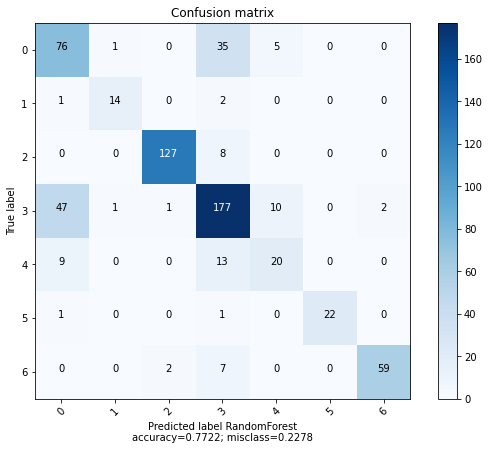

In [105]:
rf = RandomForestClassifier(n_estimators=30)
rf.fit(Xtr,ytr)

ypred = rf.predict(Xte)

print("Kappa score = ",cohen_kappa_score(yte,ypred))
cm = confusion_matrix(yte,ypred)
print("Confusion Matrix = \n",cm)


plot_confusion_matrix(cm,target_names,filename="RandomForest",title='Confusion matrix',normalize=False)

results["Random Forest"] = cohen_kappa_score(yte,ypred)
#results

Kappa score =  0.6220882425039795
Confusion Matrix = 
 [[ 55  22  12  18   8   1   1]
 [  0  13   2   2   0   0   0]
 [  0   0 127   8   0   0   0]
 [ 22  13  25 159  14   2   3]
 [  4   1   1  14  21   0   1]
 [  1   0   0   1   0  22   0]
 [  1   1   2   2   4   4  54]]


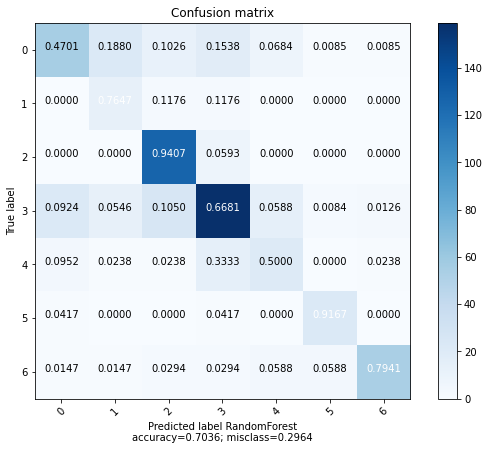

In [104]:
hnn = MvHNN_Ensemble(classifiers = rf.estimators_).fit(Xtr,ytr)
ypred = hnn.predict(Xte)

print("Kappa score = ",cohen_kappa_score(yte,ypred))

cm = confusion_matrix(yte,ypred)
print("Confusion Matrix = \n",cm)


plot_confusion_matrix(cm,target_names,filename="RandomForest",title='Confusion matrix')


results["HNN"] = cohen_kappa_score(yte,ypred)

Kappa score =  0.6202278534134811
Confusion Matrix = 
 [[ 56  18  15  18   9   0   1]
 [  0  15   0   2   0   0   0]
 [  0   0 127   8   0   0   0]
 [ 20  14  28 152  16   2   6]
 [  3   1   1  11  25   0   1]
 [  1   0   1   0   0  22   0]
 [  4   1   2   1   1   7  52]]


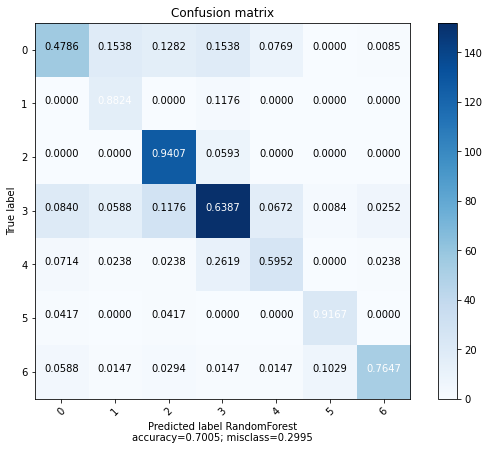

In [31]:
ecam = MvRCNN_Ensemble(classifiers = rf.estimators_, alpha = 10).fit(Xtr,ytr)
ypred = ecam.predict(Xte)

print("Kappa score = ",cohen_kappa_score(yte,ypred))
cm = confusion_matrix(yte,ypred)
print("Confusion Matrix = \n",cm)


plot_confusion_matrix(cm,target_names,filename="RandomForest",title='Confusion matrix')

results["RCNN"] = cohen_kappa_score(yte,ypred)

In [32]:
pd.DataFrame([results])

,Random Forest,HNN,RCNN
0,0.716563,0.619125,0.620228
